# Install required packages and libraries

In [ ]:
!pip install -q datasets transformers pillow opencv-python-headless matplotlib
!pip install -q tensorflow keras

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, TopKCategoricalAccuracy
import os
from PIL import Image

In [2]:
from ipywidgets import Widget
Widget.close_all()


# Import dataset and split it

In [ ]:
from google.colab import drive
from datasets import Dataset
import os

# 1. Mount Drive once
drive.mount('/content/gdrive')

# 2. Load from YOUR saved parquet files (fastest!)
gdrive_path = '/content/gdrive/MyDrive/RVL-CDIP-Dataset'

train_dataset = Dataset.from_parquet(f'{gdrive_path}/train.parquet')
val_dataset = Dataset.from_parquet(f'{gdrive_path}/validation.parquet')
test_dataset = Dataset.from_parquet(f'{gdrive_path}/test.parquet')

class_names = [
    "letter", "form", "email", "handwritten", "advertisement",
    "scientific report", "scientific publication", "specification",
    "file folder", "news article", "budget", "invoice",
    "presentation", "questionnaire", "resume", "memo"
]

print(f"✓ Datasets ready!")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

# 3. Continue with preprocessing
# (No need to call load_dataset again!)


Mounted at /content/gdrive


Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/22 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

✓ Datasets ready!
  Train: 319921
  Val: 39991
  Test: 31993


# Preprocessing Pipeline
Enhance Image Contrast
(CLAHE implementation)

Detect Document Boundaries
(Contour-based cropping)

Correct Document Skew
(Hough-based deskewing)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def apply_clahe(image_gray, clip_limit=2.0, tile_size=8):

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size, tile_size))
    enhanced = clahe.apply(image_gray)
    return enhanced


def detect_and_crop_document(image_gray):

    # Binary thresholding using Otsu's method
    _, binary = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert if needed (make foreground white, background black)
    if np.sum(binary == 255) < np.sum(binary == 0):
        binary = cv2.bitwise_not(binary)

    # Morphological operations to clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return image_gray

    # Find largest contour (assumed to be document)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Add small padding
    padding = 5
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(image_gray.shape[1] - x, w + 2 * padding)
    h = min(image_gray.shape[0] - y, h + 2 * padding)

    # Crop document
    cropped = image_gray[y:y+h, x:x+w]

    return cropped


def detect_and_correct_skew(image_gray):

    # Edge detection
    edges = cv2.Canny(image_gray, 50, 150, apertureSize=3)

    # Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

    if lines is None or len(lines) == 0:
        return image_gray

    # Extract angles from detected lines
    angles = []
    for line in lines:
        rho, theta = line[0]
        # Convert theta to degrees
        # Subtract 90 to get text line angle (not perpendicular angle)
        angle = (theta * 180 / np.pi) - 90
        angles.append(angle)

    # Find modal (most common) angle
    angles = np.array(angles)
    angles_rounded = np.round(angles, 0)

    # FIX: Extract scalar from ModeResult object
    try:
        mode_result = stats.mode(angles_rounded, keepdims=True)
        # In scipy >= 0.22, mode() returns ModeResult(mode, count)
        # Extract the mode value correctly
        if hasattr(mode_result, 'mode'):
            modal_angle = float(mode_result.mode[0])
        else:
            modal_angle = float(mode_result[0][0])
    except:
        # Fallback: use median if mode fails
        modal_angle = np.median(angles)

    # Ensure angle is in range [-45, 45]
    while modal_angle > 45:
        modal_angle -= 90
    while modal_angle < -45:
        modal_angle += 90

    # Apply rotation to correct skew
    if abs(modal_angle) > 0.5:  # Only rotate if skew is significant
        h, w = image_gray.shape
        center = (w // 2, h // 2)

        # Get rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D(center, modal_angle, 1.0)

        # Apply rotation with border replicate to avoid black edges
        deskewed = cv2.warpAffine(
            image_gray,
            rotation_matrix,
            (w, h),
            flags=cv2.INTER_CUBIC,
            borderMode=cv2.BORDER_REPLICATE
        )
        return deskewed

    return image_gray


def preprocess_image_complete(pil_image, target_size=(224, 224)):
    """
    Complete preprocessing pipeline: CLAHE → Contour Detection → Deskew → Resize

    """

    try:
        # Convert PIL to numpy
        img_array = np.array(pil_image)

        # Ensure grayscale
        if len(img_array.shape) == 3:
            img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = img_array

        # Step 1: CLAHE Enhancement
        img_clahe = apply_clahe(img_gray, clip_limit=2.0, tile_size=8)

        # Step 2: Document Boundary Detection & Cropping
        img_cropped = detect_and_crop_document(img_clahe)

        # Step 3: Skew Correction
        img_deskewed = detect_and_correct_skew(img_cropped)

        # Step 4: Resize to target size
        img_resized = cv2.resize(img_deskewed, target_size, interpolation=cv2.INTER_AREA)

        # Step 5: Normalize to [0, 1]
        img_normalized = img_resized.astype(np.float32) / 255.0

        return img_normalized

    except Exception as e:
        # Fallback: return simple resize if preprocessing fails
        print(f"Warning: Preprocessing failed - {str(e)}")
        img_array = np.array(pil_image)
        if len(img_array.shape) == 3:
            img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = img_array
        img_resized = cv2.resize(img_gray, target_size, interpolation=cv2.INTER_AREA)
        img_normalized = img_resized.astype(np.float32) / 255.0
        return img_normalized


print("✓ Fixed preprocessing functions loaded!")

✓ Fixed preprocessing functions loaded!


# Test preprocessing on sample images

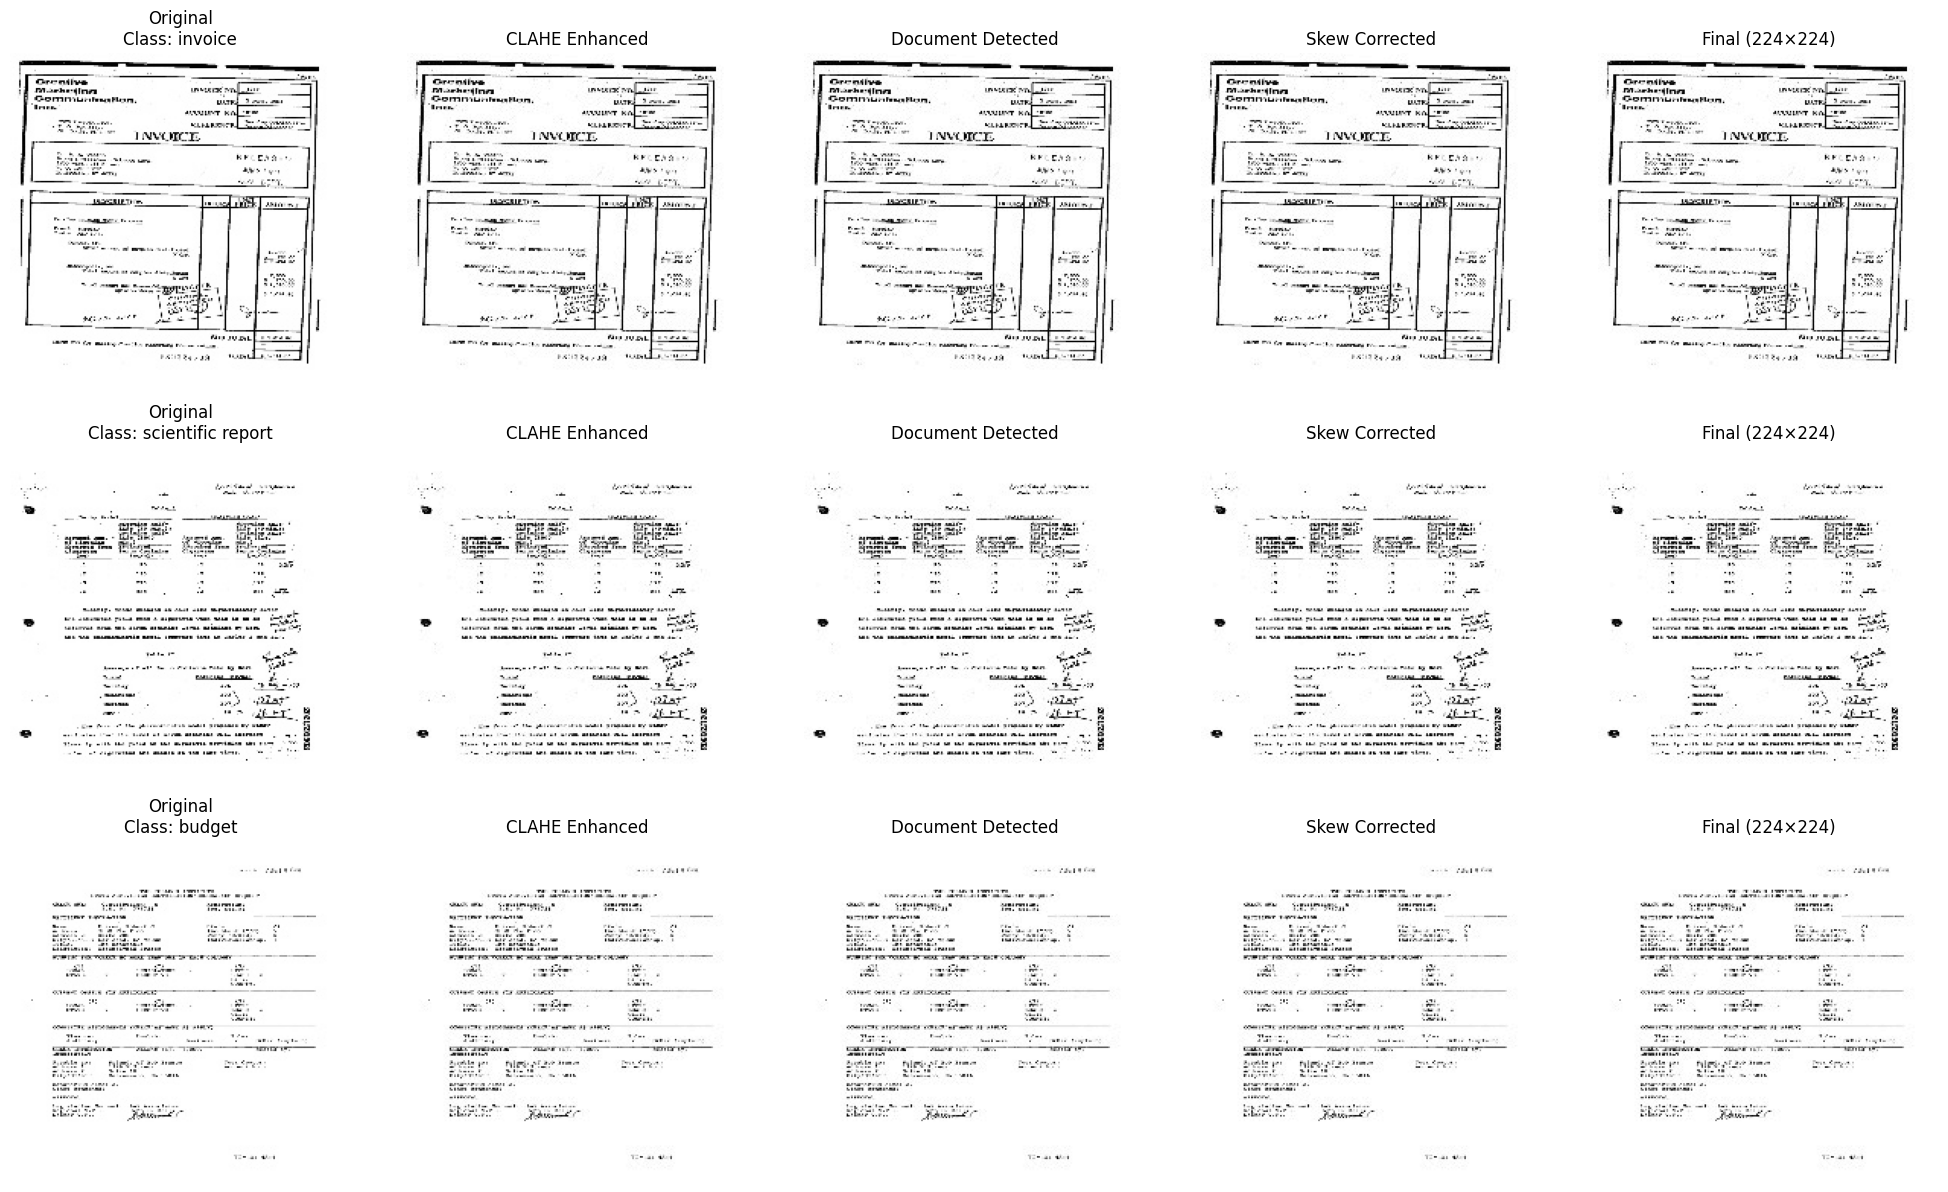

✓ Preprocessing visualization complete!


In [ ]:

import base64
from io import BytesIO

num_samples = 3
fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))

for idx in range(num_samples):
    sample = train_dataset[idx]
    # Decode base64 string to PIL Image
    image_bytes = base64.b64decode(sample['image'])
    pil_image = Image.open(BytesIO(image_bytes))

    img_array = np.array(pil_image)

    if len(img_array.shape) == 3:
        img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img_array

    # Show original
    axes[idx, 0].imshow(img_gray, cmap='gray')
    axes[idx, 0].set_title(f"Original\nClass: {sample['label']}")
    axes[idx, 0].axis('off')

    # Show CLAHE
    img_clahe = apply_clahe(img_gray)
    axes[idx, 1].imshow(img_clahe, cmap='gray')
    axes[idx, 1].set_title("CLAHE Enhanced")
    axes[idx, 1].axis('off')

    # Show after cropping
    img_cropped = detect_and_crop_document(img_clahe)
    axes[idx, 2].imshow(img_cropped, cmap='gray')
    axes[idx, 2].set_title("Document Detected")
    axes[idx, 2].axis('off')

    # Show after deskewing
    img_deskewed = detect_and_correct_skew(img_cropped)
    axes[idx, 3].imshow(img_deskewed, cmap='gray')
    axes[idx, 3].set_title("Skew Corrected")
    axes[idx, 3].axis('off')

    # Show final processed
    img_final = preprocess_image_complete(pil_image)
    axes[idx, 4].imshow(img_final, cmap='gray')
    axes[idx, 4].set_title("Final (224×224)")
    axes[idx, 4].axis('off')

plt.tight_layout()
plt.show()

print("✓ Preprocessing visualization complete!")

Processed image: shape=(224, 224), min=0.003921568859368563, max=1.0


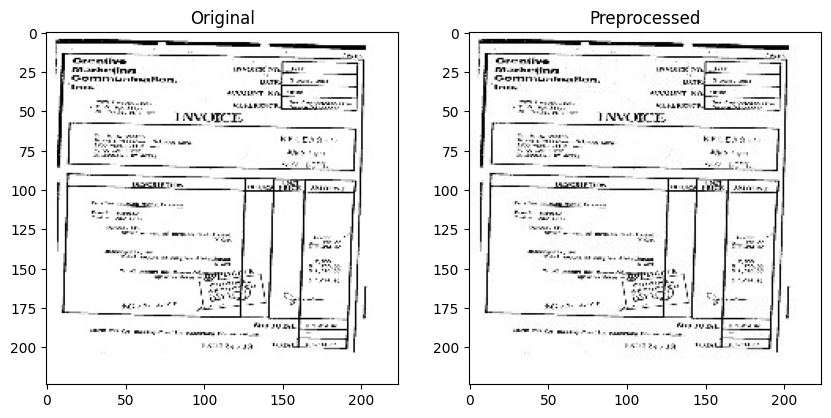

In [ ]:
import base64
from io import BytesIO

# Test preprocessing directly
sample = train_dataset[0]

# Decode base64 string to PIL Image
image_bytes = base64.b64decode(sample['image'])
pil_image = Image.open(BytesIO(image_bytes))

processed = preprocess_image_complete(pil_image)
print(f"Processed image: shape={processed.shape}, min={processed.min()}, max={processed.max()}")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# Convert back to PIL Image for visualization if original is needed
original_pil_image = Image.open(BytesIO(base64.b64decode(sample['image'])))
plt.imshow(original_pil_image, cmap='gray')
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(processed, cmap='gray')
plt.title("Preprocessed")
plt.show()


#    Create TensorFlow dataset with preprocessing

    Args:
        hf_dataset: Hugging Face dataset split
        batch_size: Batch size for training
        shuffle: Whether to shuffle data
        subset_size: Use subset for quick testing (None = full dataset)
        num_samples_to_process: Show progress for first N samples

    Returns:
        tf.data.Dataset
    

In [ ]:
import tensorflow as tf
from tensorflow.data import Dataset as TFDataset
from PIL import Image
import base64
from io import BytesIO

def create_tf_dataset_optimized(hf_dataset, batch_size=32, shuffle=True,
                                  subset_size=None, num_samples_to_process=None):

    # Use subset if specified
    if subset_size:
        hf_dataset = hf_dataset.select(range(min(subset_size, len(hf_dataset))))

    def generator():
        for i, sample in enumerate(hf_dataset):
            # Decode base64 string to PIL Image before preprocessing
            image_bytes = base64.b64decode(sample['image'])
            pil_image = Image.open(BytesIO(image_bytes))

            img = preprocess_image_complete(pil_image)
            # Convert string label to integer index
            label = class_names.index(sample['label'])

            # Show progress for first N samples
            if num_samples_to_process and i < num_samples_to_process and i % 100 == 0:
                print(f"  Processing {i+1}/{len(hf_dataset)}...")

            yield img, label

    # Create TensorFlow dataset
    output_signature = (
        tf.TensorSpec(shape=(224, 224), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )

    tf_dataset = TFDataset.from_generator(generator, output_signature=output_signature)

    # Add channel dimension (224, 224) → (224, 224, 1)
    tf_dataset = tf_dataset.map(lambda x, y: (tf.expand_dims(x, -1), y))

    if shuffle:
        tf_dataset = tf_dataset.shuffle(buffer_size=min(1000, len(hf_dataset)))

    tf_dataset = tf_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return tf_dataset


# Create datasets (using smaller subset for demo - remove for full training)
print("Creating TensorFlow datasets with preprocessing...")
print("Train dataset:")
train_tf = create_tf_dataset_optimized(train_dataset, batch_size=32, shuffle=True,
                                       subset_size=2000, num_samples_to_process=2000)

print("Validation dataset:")
val_tf = create_tf_dataset_optimized(val_dataset, batch_size=32, shuffle=False,
                                     subset_size=500)

print("Test dataset:")
test_tf = create_tf_dataset_optimized(test_dataset, batch_size=32, shuffle=False,
                                      subset_size=500)

print("✓ TensorFlow datasets created!")

Creating TensorFlow datasets with preprocessing...
Train dataset:
Validation dataset:
Test dataset:
✓ TensorFlow datasets created!


# VGG-style CNN architecture for document classification

    Architecture:
    - 4 Conv blocks (3×3 kernels, progressive filters: 32→64→128→256)
    - Batch normalization after each conv
    - Max pooling and dropout for regularization
    - 2 fully connected layers with dropout

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, TopKCategoricalAccuracy

def build_vgg_style_cnn(input_shape=(224, 224, 1), num_classes=16):

    model = models.Sequential(name="VGG_Style_DocClassifier")

    # Block 1: 32 filters
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 2: 64 filters
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 3: 128 filters
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 4: 256 filters
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))  # Linear output for logits

    return model


# Build model
model = build_vgg_style_cnn()
model.summary()


Model: "VGG_Style_DocClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,615,600 (105.35 MB)

 Trainable params: 27,611,888 (105.33 MB)

 Non-trainable params: 3,712 (14.50 KB)

# Compile and train model

In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy #, TopKCategoricalAccuracy

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        SparseCategoricalAccuracy(name='accuracy')
        # TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
    ]
)

print("✓ Model compiled successfully!")

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7
)

# Train model
print("Training model...")
history = model.fit(
    train_tf,
    validation_data=val_tf,
    epochs=10,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("✓ Training complete!")

In [ ]:
print("Evaluating on test set...")
test_results = model.evaluate(test_tf, verbose=1)

print(f"\n=== Test Results ===")
print(f"Loss: {test_results[0]:.4f}")
print(f"Top-1 Accuracy: {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")

# Predict document class with confidence scores

    Returns:
        - top_predictions: List of (class_name, confidence) tuples
        - all_probs: Full probability distribution

In [ ]:
def predict_with_confidence(model, pil_image, class_names, top_k=3):

    # Preprocess
    img = preprocess_image_complete(pil_image)
    img = np.expand_dims(img, axis=-1)  # Add channel
    img = np.expand_dims(img, axis=0)   # Add batch

    # Get logits
    logits = model.predict(img, verbose=0)

    # Convert to probabilities
    probs = tf.nn.softmax(logits).numpy()

    # Get top-k
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_predictions = [(class_names[i], float(probs[i])) for i in top_indices]

    return top_predictions, probs


# Test on sample
sample_idx = 100
sample = test_dataset[sample_idx]
predictions, probs = predict_with_confidence(model, sample['image'], class_names, top_k=3)

print(f"True label: {class_names[sample['label']]}")
print(f"\nTop-3 Predictions:")
for i, (cls, conf) in enumerate(predictions, 1):
    print(f"  {i}. {cls}: {conf:.2%}")

# Low confidence flag
if predictions < 0.5:
    print(f"\n⚠️ Low confidence - Flag for manual review")


In [ ]:
# Save model
model_path = f'{gdrive_path}/rvl_cdip_model.h5'
model.save(model_path)
print(f"✓ Model saved to {model_path}")

# Save as SavedModel format (better for serving)
savedmodel_path = f'{gdrive_path}/rvl_cdip_model_savedmodel'
model.save(savedmodel_path)
print(f"✓ Model saved as SavedModel to {savedmodel_path}")
